In [2]:
import numpy as np
import librosa, soundfile as sf
from scipy.signal import butter, sosfiltfilt, resample_poly
from dataclasses import dataclass

In [3]:
HAS_GT = False
try:
    from gammatone.gtgram import gtgram
    HAS_GT = True
except Exception:
    HAS_GT = False
    
# Load audio file
# normalize audio
# simple vad
def load_trim_normalize(
    path,
    sr=16000,
    top_db=40,
):
    y, sr = librosa.load(path, sr=sr, mono=True)
    
    # RMS normalization
    rms = np.sqrt(np.mean(y**2) + 1e-12)
    
    if rms > 0:
        y = y / rms
        
    # Trim silence
    y, _ = librosa.effects.trim(y, top_db=top_db)
    return y, sr

# Cochleagram
# gammatone + envelope + PCEN + LPF + 1kHz downsample
@dataclass
class CochleagramConfig:
    n_channels: int = 64
    f_min: float = 50.0
    f_max: float = 8000.0
    env_fs: int = 1000 # Hz after downsampling
    lpf_hz: int = 200 # low-pass envelope
    compression: str = 'pcen' # 'pcen', 'log', 'linear'
    per_channel_zscore: bool = True

def lowpass_sos(
    x,
    sr,
    cutoff
):
    if cutoff is None:
        return x
    sos = butter(
        4,
        cutoff/(0.5 * sr),
        btype='low',
        output='sos'
    )
    return sosfiltfilt(sos, x, axis=1)

def cochleagram_pcen(
    y,
    sr,
    cfg=CochleagramConfig()
):
    hop = 1.0 / cfg.env_fs
    if HAS_GT:
        env = gtgram(
            y,
            sr,
            window_time=0.025,
            hop_time=hop,
            channels=cfg.n_channels,
            f_min=cfg.f_min
        )
    else:
        n_fft = int(round(0.025 * sr))
        hop_len = int(round(hop * sr))
        
        S = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_fft=n_fft,
            hop_length=hop_len,
            fmin=cfg.f_min,
            fmax=cfg.f_max,
            n_mels=cfg.n_channels,
            power=1.0
        )
        env = S + 1e-10
    
    # PCEN compression
    if cfg.compression == 'pcen':
        env = librosa.pcen(
            env,
            sr=cfg.env_fs,
            time_constant=0.06,
            eps=1e-6
        )
    else:
        env = np.log1p(env)
        
    # Low-pass filter 200 Hz
    env = lowpass_sos(
        env,
        cfg.env_fs,
        cfg.lpf_hz
    )
    
    # per-utterance per-channel normalization
    if cfg.per_channel_zscore:
        mean = np.mean(env, axis=1, keepdims=True)
        std = np.std(env, axis=1, keepdims=True) + 1e-8
        env = (env - mean) / (std)
    
    return env.astype(np.float32), cfg.env_fs

# LIF encoding + threshold calibration
@dataclass
class LIFConfig:
    tau: float = 0.02 # membrane time constant in seconds
    dt: float = 0.001 # simulation time step in seconds
    v_reset: float = 0.0 # reset potential  
    refractory: float = 0.005 # refractory period in seconds
    target_rate: float = 60.0 # target firing rate in Hz
    max_iter: int = 20

def lif_simulate(
    env_1d,
    theta,
    cfg: LIFConfig
):
    T = env_1d.shape[-1]
    u = 0.0
    spikes = np.zeros(T, dtype=np.uint8)
    t_ref = 0.0
    for t in range(T):
        if t_ref > 0:
            t_ref -= cfg.dt
            u = cfg.v_reset
        else:
            u += (cfg.dt / cfg.tau) * (env_1d[t] - u)
            if u >= theta:
                spikes[t] = 1
                u = cfg.v_reset
                t_ref = cfg.refractory
    rate = spikes.sum() / (T * cfg.dt)
    return spikes, rate

def caliberate_theta(
    env_1d,
    cfg: LIFConfig
):
    lo, hi = np.percentile(env_1d, 10), np.percentile(env_1d, 99.9)
    theta = (lo + hi) / 2.0
    for _ in range(cfg.max_iter):
        _, r = lif_simulate(
            env_1d,
            theta,
            cfg
        )
        if r < cfg.target_rate:
            theta = (theta + hi) / 2.0
        else:
            theta = (theta + lo) / 2.0
    return float(theta)

def lif_encode_calibrated(
    env,
    fs_env,
    lif=LIFConfig()
):
    assert abs(1.0/lif.dt - fs_env) < 1e-6, "lif.dt must match 1/fs_env"
    n_channels, T = env.shape
    spikes = np.zeros((n_channels, T), dtype=np.uint8)
    thetas = np.zeros(n_channels, dtype=np.float32)
    for i in range(n_channels):
        th = caliberate_theta(
            env[i],
            lif
        )
        thetas[i] = th
        spikes[i], _ = lif_simulate(
            env[i],
            th,
            lif
        )
    return spikes, thetas

Envelope shape: (32, 232), fs_env: 1000


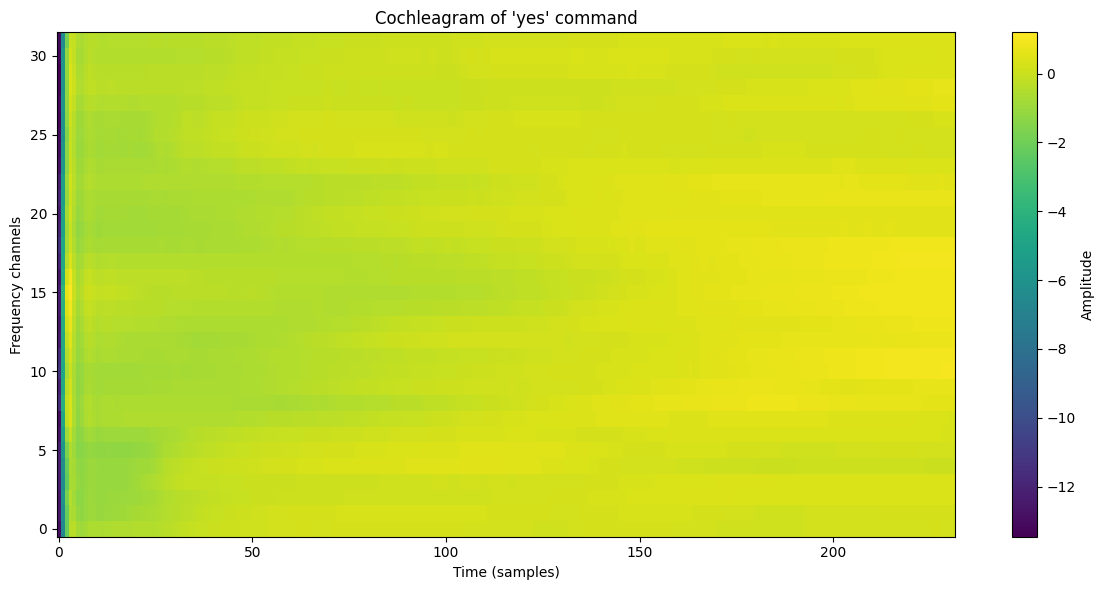

Spikes shape: (32, 232), Thetas: [-0.47532427 -0.6291939  -0.7471792  -0.68100685 -0.7728091  -0.94723725
 -0.8175402  -0.5497539   0.8099381  -0.7045876   0.9751992   0.9525002
 -0.6808403   0.84022826  0.9552898   1.1326373   0.9255296   0.9419213
  0.8731845  -0.78486174 -0.77081686 -0.67416066 -0.5522096  -0.63092947
 -0.6180372  -0.49750862 -0.5283696   0.608618    0.6518515  -0.33104837
 -0.46841148 -0.40091985]


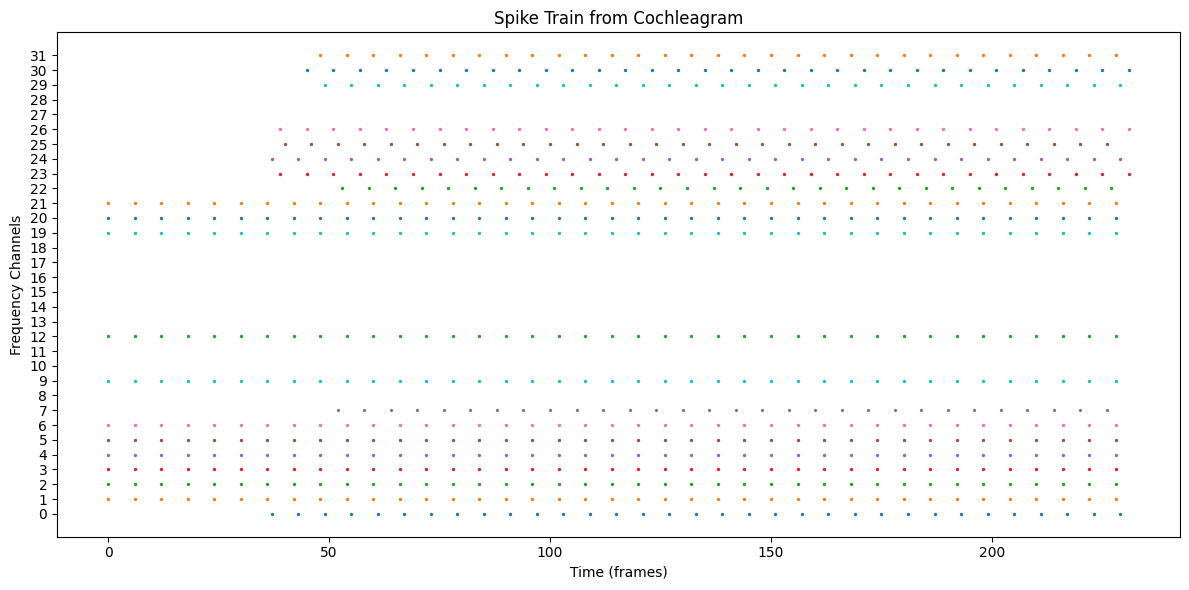

In [5]:
import matplotlib.pyplot as plt
path = "speech_command_dataset_v2/dataset/yes/0a396ff2_nohash_0.wav"

y, sr = load_trim_normalize(path, sr=16000, top_db=40)

coch_cfg = CochleagramConfig(
    n_channels=32,
    f_min=80.0,
    f_max=8000.0,
    env_fs=1000,
    lpf_hz=200,
    compression='pcen',
    per_channel_zscore=True
)
env, fs_env = cochleagram_pcen(y, sr, coch_cfg)

print(f"Envelope shape: {env.shape}, fs_env: {fs_env}")
plt.figure(figsize=(12, 6))
plt.imshow(env, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title("Cochleagram of 'yes' command")
plt.xlabel("Time (samples)")
plt.ylabel("Frequency channels")
plt.tight_layout()
plt.show()

lif_cfg = LIFConfig(
    tau=0.02,
    dt=0.001,
    v_reset=0.0,
    refractory=0.005,
    target_rate=60.0,
    max_iter=20
)
spikes, thetas = lif_encode_calibrated(env, fs_env, lif_cfg)
print(f"Spikes shape: {spikes.shape}, Thetas: {thetas}")
fig, ax = plt.subplots(figsize=(12, 6))
for ch in range(spikes.shape[0]):
    times = np.where(spikes[ch])[0]
    ax.scatter(times, [ch]*len(times), s=2)
ax.set_title("Spike Train from Cochleagram")
ax.set_xlabel("Time (frames)")
ax.set_ylabel("Frequency Channels")
ax.set_yticks(np.arange(spikes.shape[0]))
plt.tight_layout()
plt.show()

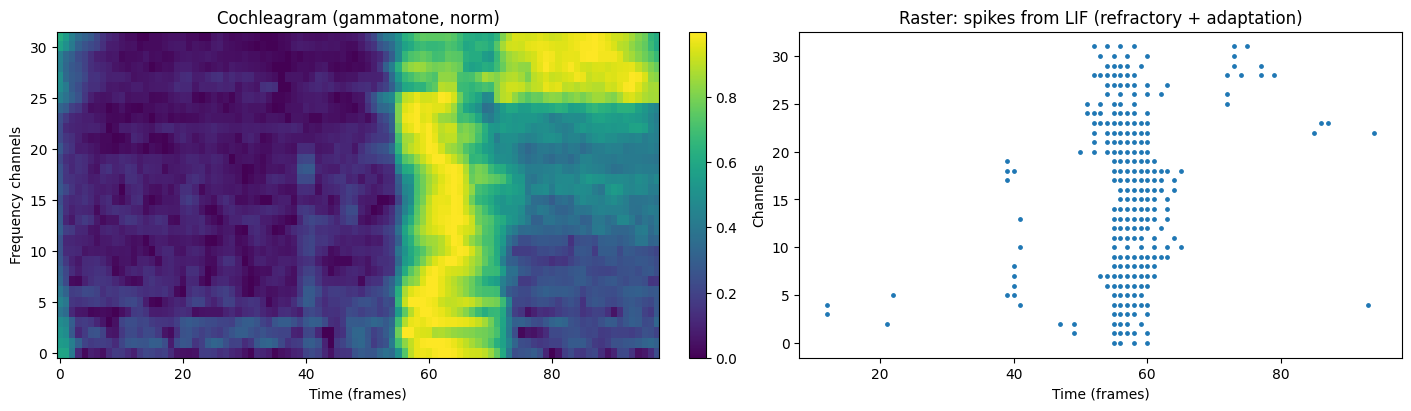

Mean firing rate (Hz): 8.0 ± 1.8
Median CV(ISI): 1.15 (target ~0.7–1.2 is good)


In [13]:
## ANOTHER VERSION
import numpy as np
import librosa
import matplotlib.pyplot as plt
from gammatone.gtgram import gtgram  # pip install gammatone

# -------------------------------
# 1) Cochleagram (gammatone)
# -------------------------------
def compute_cochleagram(y, sr, n_ch=32, win_ms=25, hop_ms=10, f_min=80):
    win = win_ms / 1000.0
    hop = hop_ms / 1000.0
    # gtgram returns (n_ch, T)
    C = gtgram(y, sr, win, hop, n_ch, f_min)
    # dB-like compression, then min-max to [0,1] per channel
    C = np.log10(C + 1e-10)
    C = (C - C.min(axis=1, keepdims=True)) / (C.ptp(axis=1, keepdims=True) + 1e-9)
    dt = hop  # time per frame (s)
    return C, dt

# -------------------------------
# 2) (Optional) Onset emphasis
# -------------------------------
def emphasize_onset(C, dt, tau_hp=0.03):
    """
    High-pass in time via EMA, return relu(C - EMA(C)).
    """
    n_ch, T = C.shape
    alpha = dt / max(tau_hp, 1e-6)
    ema = np.zeros_like(C)
    out = np.zeros_like(C)
    for t in range(T):
        ema[:, t] = (1 - alpha) * (ema[:, t-1] if t > 0 else C[:, 0]) + alpha * C[:, t]
        out[:, t] = np.maximum(0.0, C[:, t] - ema[:, t])
    # rescale each channel to [0,1]
    out = (out - out.min(axis=1, keepdims=True)) / (out.ptp(axis=1, keepdims=True) + 1e-9)
    return out

# -------------------------------
# 3) LIF encoder (refractory + adaptive threshold + noise)
# -------------------------------
def lif_encode(
    C, dt,
    tau_m=0.02, v_reset=0.0,
    thresh_mode='percentile', pct=90, k_sigma=1.2,
    refractory=0.004,
    adapt_jump=0.10, tau_theta=0.05,
    noise_std=0.02, seed=0,
    gain=1.0                  # <— mới: nhân độ lớn input
):
    rng = np.random.default_rng(seed)
    n_ch, T = C.shape
    C = np.clip(C * gain, 0.0, 1.0)     # scale nhanh

    if thresh_mode == 'percentile':
        theta_base = np.percentile(C, pct, axis=1)
    else:
        mu = C.mean(axis=1); sd = C.std(axis=1) + 1e-9
        theta_base = mu + k_sigma * sd
    theta_base *= rng.normal(1.0, 0.05, size=n_ch)  # dị thể kênh

    v = np.zeros(n_ch); theta = theta_base.copy()
    spikes = np.zeros((n_ch, T), np.uint8)
    last_spike_t = np.full(n_ch, -1e9)
    tau_m_ch = tau_m * rng.normal(1.0, 0.05, size=n_ch)

    for t in range(T):
        I = C[:, t]
        dv = (I - v) / tau_m_ch * dt
        if noise_std > 0:
            dv += noise_std * np.sqrt(dt) * rng.standard_normal(n_ch)
        v += dv

        can_spike = ((t*dt) - last_spike_t) >= refractory
        fired = (v >= theta) & can_spike
        spikes[fired, t] = 1
        last_spike_t[fired] = t*dt
        v[fired] = v_reset

        theta[fired] += adapt_jump * theta_base[fired]
        theta += (theta_base - theta) * (dt / max(tau_theta, 1e-6))
    return spikes

# -------------------------------
# 4) Quick demo on one file
# -------------------------------
def demo_on_file(path, n_ch=32, onset=True, win_ms=25, hop_ms=10):
    y, sr = librosa.load(path, sr=16000)
    y = librosa.effects.preemphasis(y, coef=0.97)
    y = librosa.util.normalize(y)

    C, dt = compute_cochleagram(y, sr, n_ch=n_ch, win_ms=win_ms, hop_ms=hop_ms)
    C_vis = C.copy()
    if onset:
        C = emphasize_onset(C, dt, tau_hp=0.03)

    S = lif_encode(
        C, dt,
        tau_m=0.03, 
        refractory=0.005,
        thresh_mode='percentile', pct=84,
        adapt_jump=0.02, 
        tau_theta=0.05,
        noise_std=0.06, 
        seed=42,
        gain=1.5
    )

    # Plots
    fig, ax = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)
    im = ax[0].imshow(C_vis, aspect='auto', origin='lower')
    ax[0].set_title("Cochleagram (gammatone, norm)")
    ax[0].set_xlabel("Time (frames)")
    ax[0].set_ylabel("Frequency channels")
    fig.colorbar(im, ax=ax[0])

    ch, t = np.nonzero(S)
    ax[1].scatter(t, ch, s=6)
    ax[1].set_title("Raster: spikes from LIF (refractory + adaptation)")
    ax[1].set_xlabel("Time (frames)")
    ax[1].set_ylabel("Channels")
    plt.show()

    # A quick sanity check: mean rate and CV(ISI)
    rates = S.mean(axis=1) / dt  # Hz
    isi_cvs = []
    for c in range(S.shape[0]):
        ts = np.where(S[c] == 1)[0] * dt
        if len(ts) > 2:
            isi = np.diff(ts)
            isi_cvs.append(np.std(isi) / (np.mean(isi) + 1e-9))
    print(f"Mean firing rate (Hz): {rates.mean():.1f} ± {rates.std():.1f}")
    if isi_cvs:
        print(f"Median CV(ISI): {np.median(isi_cvs):.2f} (target ~0.7–1.2 is good)")

# Example call:
# demo_on_file("/path/to/speech_commands/yes/xxxx.wav", n_ch=32, onset=True)
demo_on_file("speech_command_dataset_v2/dataset/yes/0f3f64d5_nohash_0.wav", n_ch=32, onset=True)

In [2]:
# Yet another approach
# === Stable audio→cochlea→LIF spikes with dataset-wide norm + target-rate tuning ===
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import os

# --------------------------
# 0) Utilities
# --------------------------
def vad_trim(y, sr, top_db=30, pad_s=0.05):
    """Energy VAD (librosa) + pad both sides."""
    intervals = librosa.effects.split(y, top_db=top_db)
    if len(intervals) == 0:
        return y  # nothing detected
    start = max(0, intervals[0,0] - int(pad_s*sr))
    end   = min(len(y), intervals[-1,1] + int(pad_s*sr))
    return y[start:end]

def compute_cochleagram(y, sr, n_ch=32, win_ms=25, hop_ms=10, fmin=80, fmax=None):
    """Cochleagram placeholder using Mel filterbank (stable & fast).
       Drop-in replace with your gammatone if muốn.
       Returns (n_ch, T) float32 in [0,1] after per-file minmax (mild) for visualization.
    """
    win = int(sr*win_ms/1000)
    hop = int(sr*hop_ms/1000)
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=2**int(np.ceil(np.log2(win))),
        hop_length=hop, win_length=win, window="hann",
        n_mels=n_ch, fmin=fmin, fmax=fmax, power=1.0, center=True, htk=True
    )  # shape (n_ch, T)
    # amplitude compression (√) + small per-file minmax ONLY for display
    S = np.sqrt(S + 1e-12)
    return S.astype(np.float32)  # (n_ch, T)

# --------------------------
# 1) Dataset-wide normalisation (fit on TRAIN only)
# --------------------------
def fit_cochlea_norm(train_files, sr=16000, **coch_kwargs):
    """Compute per-channel mean/std across train set (after VAD)."""
    ch = None
    m_sum, v_sum, n_total = None, None, 0
    for p in train_files:
        y, _sr = librosa.load(p, sr=sr, mono=True)
        y = vad_trim(y, sr)
        C = compute_cochleagram(y, sr, **coch_kwargs)  # (n_ch, T)
        if ch is None:
            ch = C.shape[0]
            m_sum = np.zeros(ch, dtype=np.float64)
            v_sum = np.zeros(ch, dtype=np.float64)
        m_sum += C.mean(axis=1)
        v_sum += C.var(axis=1)
        n_total += 1
    mean = (m_sum / max(n_total,1)).astype(np.float32)
    std  = np.sqrt(v_sum / max(n_total,1) + 1e-8).astype(np.float32)
    return {"mean": mean, "std": std, "sr": sr, "coch_kwargs": coch_kwargs}

def apply_norm(C, stats, per_channel=True):
    """z-score using dataset stats; keep nonnegative by linear scaling."""
    if per_channel:
        Cn = (C - stats["mean"][:, None]) / (stats["std"][:, None] + 1e-8)
    else:
        mu, sd = C.mean(), C.std()
        Cn = (C - mu) / (sd + 1e-8)
    # squash to [0,1] with robust sigmoid-ish mapping
    Cn = 1/(1+np.exp(-Cn))  # in (0,1)
    return Cn.astype(np.float32)

# --------------------------
# 2) LIF with refractory + simple adaptation
# --------------------------
def lif_encode(C01, dt, tau_m=0.02, v0=0.15, gain=1.0,
               refrac_s=0.003, a_jump=0.12, tau_a=0.08):
    """C01: (n_ch, T) in [0,1]. Returns spikes (n_ch, T) {0,1}."""
    n_ch, T = C01.shape
    dt = float(dt)
    v = np.zeros(n_ch, dtype=np.float32)
    a = np.zeros(n_ch, dtype=np.float32)
    refrac = np.zeros(n_ch, dtype=np.float32)
    spikes = np.zeros((n_ch, T), dtype=np.uint8)

    # precompute constants
    decay_m = np.exp(-dt/tau_m)
    decay_a = np.exp(-dt/tau_a)
    refrac_steps = int(round(refrac_s/dt))

    for t in range(T):
        drive = gain * C01[:, t]  # [0, gain]
        # integrate only if not refractory
        active = (refrac <= 0.5)
        v[active] = v[active]*decay_m + (1-decay_m)*drive[active]
        a = a*decay_a
        thr = v0 * (1.0 + a)  # adaptive threshold

        # spike
        s = (v > thr) & active
        spikes[s, t] = 1
        # reset + adaptation
        v[s] = 0.0
        a[s] += a_jump
        refrac[s] = refrac_steps

        # update refrac timers
        refrac[refrac>0] -= 1.0
    return spikes

# --------------------------
# 3) Target firing-rate tuning loop (per file) – keeps params within bounds
# --------------------------
def encode_with_rate_target(Cn, dt, target_hz=8.0, tol=1.0, max_iter=6,
                            init_pct=0.80, init_gain=1.0,
                            pct_bounds=(0.60,0.95), gain_bounds=(0.6, 3.5),
                            **lif_kw):
    """Scale cochlea then LIF so that mean firing rate ≈ target_hz."""
    pct, gain = init_pct, init_gain
    # scale by percentile per FILE to reduce outliers (mild)
    flat = Cn.ravel()
    for _ in range(max_iter):
        scale = np.percentile(flat, pct*100)
        C01 = np.clip(Cn/ (scale + 1e-8), 0, 1)
        S = lif_encode(C01, dt, gain=gain, **lif_kw)
        rate = S.sum() / (S.shape[0]*S.shape[1]*dt)  # Hz

        if rate < target_hz - tol:
            pct = max(pct_bounds[0], pct - 0.03)
            gain = min(gain_bounds[1], gain * 1.15)
        elif rate > target_hz + tol:
            pct = min(pct_bounds[1], pct + 0.03)
            gain = max(gain_bounds[0], gain * 0.85)
        else:
            return S, {"pct":pct, "gain":gain, "rate":rate}
    # return last
    return S, {"pct":pct, "gain":gain, "rate":rate}

# --------------------------
# 4) End-to-end: fit stats, then encode 1 file and plot
# --------------------------
def encode_file(path, stats,
                target_hz=8.0, tol=1.0,
                win_ms=25, hop_ms=10,
                init_pct=0.95, init_gain=0.4,
                v0=0.15, tau_m=0.02, refrac_s=0.003, a_jump=0.12, tau_a=0.08):
    sr = stats["sr"]
    y, _ = librosa.load(path, sr=sr, mono=True)
    y = vad_trim(y, sr)
    C = compute_cochleagram(y, sr, **stats["coch_kwargs"])  # (n_ch, T)
    Cn = apply_norm(C, stats, per_channel=True)
    dt = hop_ms/1000.0
    S, info = encode_with_rate_target(
        Cn, dt, target_hz=target_hz, tol=tol,
        init_pct=init_pct, init_gain=init_gain,
        tau_m=tau_m, v0=v0, refrac_s=refrac_s, a_jump=a_jump, tau_a=tau_a
    )
    return C, Cn, S, info, dt

def plot_debug(C, S, dt, title=""):
    n_ch, T = C.shape
    fig = plt.figure(figsize=(12, 4))

    ax1 = plt.subplot(1, 2, 1)
    # giữ handle trả về từ specshow
    im = librosa.display.specshow(C, x_axis=None, y_axis=None, sr=1, hop_length=1, ax=ax1)
    ax1.set_title("Cochleagram (normed)")
    # dùng handle để tạo colorbar
    fig.colorbar(im, ax=ax1, format="%.2f")

    ax2 = plt.subplot(1, 2, 2)
    i, t = np.nonzero(S)
    ax2.scatter(t, i, s=6)
    ax2.set_title("Raster")
    ax2.set_xlabel("Time (frames)")
    ax2.set_ylabel("Channels")

    # quick stats
    isi = []
    for ch in range(S.shape[0]):
        ts = np.where(S[ch])[0]
        if len(ts) > 2:
            isi.extend(np.diff(ts) * dt)
    rate = S.sum() / (S.shape[0] * S.shape[1] * dt)
    cv = (np.std(isi) / np.mean(isi)) if len(isi) > 5 else float("nan")

    plt.suptitle(f"{title} | mean rate {rate:.1f} Hz, CV(ISI) {cv:.2f}")
    plt.tight_layout()
    plt.show()
    

# ==========================
# EXAMPLE USAGE
# ==========================
# 1) Fit normalisation on training files (list of paths)
trainfiles = []
for path in os.listdir("speech_command_dataset_v2/dataset/yes"):
    trainfiles.append(os.path.join("speech_command_dataset_v2/dataset/yes", path))
for path in os.listdir("speech_command_dataset_v2/dataset/no"):
    trainfiles.append(os.path.join("speech_command_dataset_v2/dataset/no", path))

stats = fit_cochlea_norm(trainfiles, sr=16000, n_ch=32, win_ms=25, hop_ms=10, fmin=80, fmax=7600)


Chosen pct/gain & achieved rate: {'pct': 0.95, 'gain': 0.6, 'rate': 8.984375}


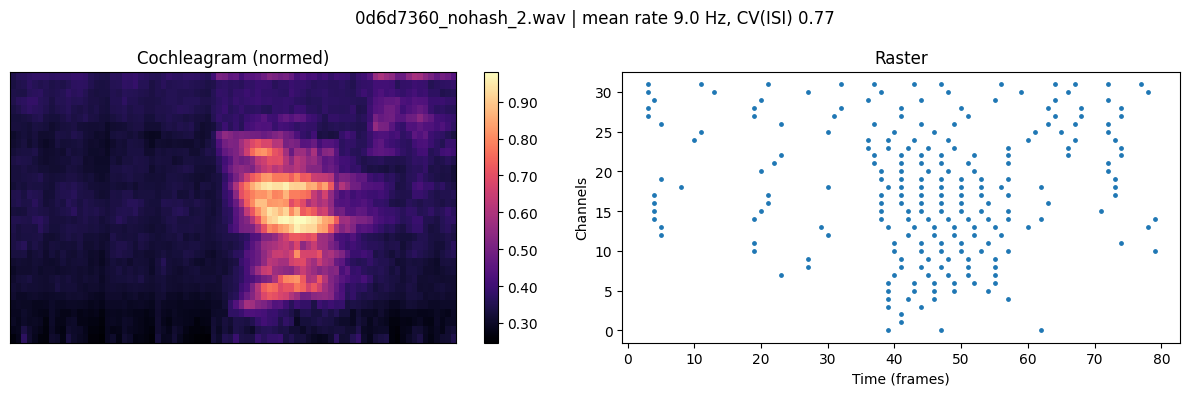

In [3]:
# 2) Encode a file with rate targeting (use same stats for ALL files)
path = "speech_command_dataset_v2/dataset/yes/0d6d7360_nohash_2.wav"
C, Cn, S, info, dt = encode_file(path, stats, target_hz=8.0, tol=1.0,
                                 init_gain=0.6, init_pct=0.95,
                                  v0=0.29, tau_m=0.015, refrac_s=0.003, a_jump=0.42, tau_a=0.07)
print("Chosen pct/gain & achieved rate:", info)
plot_debug(Cn, S, dt, title=path.split("/")[-1])

Chosen pct/gain & achieved rate: {'pct': 0.95, 'gain': 0.6, 'rate': 11.838942307692307}


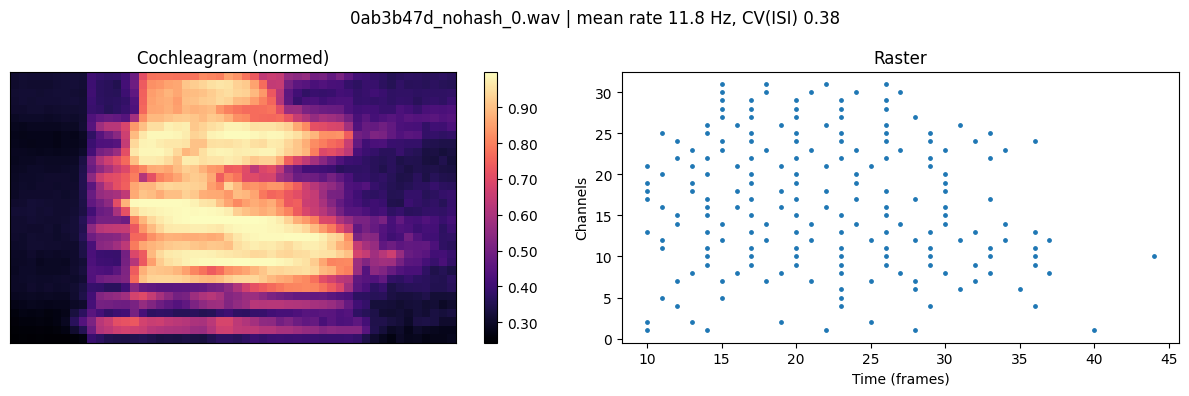

In [4]:
path = "speech_command_dataset_v2/dataset/no/0ab3b47d_nohash_0.wav"
C, Cn, S, info, dt = encode_file(path, stats, target_hz=8.0, tol=1.0,
                                 init_gain=0.6, init_pct=0.95,
                                  v0=0.29, tau_m=0.015, refrac_s=0.003, a_jump=0.42, tau_a=0.07)
print("Chosen pct/gain & achieved rate:", info)
plot_debug(Cn, S, dt, title=path.split("/")[-1])

In [5]:
def median_rate(S_list, dt):
    rate = []
    cv = []
    for S in S_list:
        isi = []
        for ch in range(S.shape[0]):
            ts = np.where(S[ch])[0]
            if len(ts) > 2:
                isi.extend(np.diff(ts) * dt)
        rate.append(S.sum() / (S.shape[0] * S.shape[1] * dt))
        cv.append((np.std(isi) / np.mean(isi)) if len(isi) > 5 else float("nan"))
    return np.median(rate), np.median(cv)
file_list = []
iter = 0
for path in os.listdir("speech_command_dataset_v2/dataset/yes"):
    file_list.append(os.path.join("speech_command_dataset_v2/dataset/yes", path))
    iter += 1
    if iter >= 100:  # limit to 10 files for quick demo
        break
for path in os.listdir("speech_command_dataset_v2/dataset/no"):
    file_list.append(os.path.join("speech_command_dataset_v2/dataset/no", path))
    iter += 1
    if iter >= 100:  # limit to 20 files for quick demo
        break

S_list = []
for path in file_list:
    C, Cn, S, info, dt = encode_file(path, stats, target_hz=8.0, tol=1.0,
                                     init_gain=0.6, init_pct=0.95,
                                      v0=0.29, tau_m=0.015, refrac_s=0.003, a_jump=0.42, tau_a=0.07)
    print(S.shape)
    S_list.append(S)

median_rate_value, median_cv = median_rate(S_list, dt)
print(f"Median firing rate: {median_rate_value:.2f} Hz, Median CV(ISI): {median_cv:.2f}")

(32, 71)
(32, 101)
(32, 68)
(32, 78)
(32, 54)
(32, 90)
(32, 59)
(32, 55)
(32, 80)
(32, 61)
(32, 101)
(32, 62)
(32, 70)
(32, 70)
(32, 101)
(32, 62)
(32, 71)
(32, 80)
(32, 84)
(32, 90)
(32, 68)
(32, 101)
(32, 70)
(32, 97)
(32, 101)
(32, 78)
(32, 65)
(32, 101)
(32, 93)
(32, 59)
(32, 90)
(32, 71)
(32, 49)
(32, 57)
(32, 62)
(32, 99)
(32, 83)
(32, 70)
(32, 65)
(32, 92)
(32, 64)
(32, 70)
(32, 68)
(32, 99)
(32, 62)
(32, 101)
(32, 101)
(32, 84)
(32, 68)
(32, 74)
(32, 64)
(32, 101)
(32, 42)
(32, 43)
(32, 65)
(32, 62)
(32, 68)
(32, 57)
(32, 101)
(32, 45)
(32, 70)
(32, 101)
(32, 101)
(32, 96)
(32, 93)
(32, 101)
(32, 47)
(32, 32)
(32, 99)
(32, 65)
(32, 101)
(32, 70)
(32, 66)
(32, 101)
(32, 60)
(32, 59)
(32, 65)
(32, 66)
(32, 73)
(32, 61)
(32, 96)
(32, 71)
(32, 101)
(32, 68)
(32, 74)
(32, 48)
(32, 59)
(32, 101)
(32, 55)
(32, 54)
(32, 70)
(32, 39)
(32, 101)
(32, 81)
(32, 101)
(32, 31)
(32, 77)
(32, 59)
(32, 45)
(32, 58)
(32, 65)
Median firing rate: 10.43 Hz, Median CV(ISI): 0.70
